# Image Classifier for 4 Types of Balls using Fastai and SageMaker Studio IDE
> This is a practice notebook to use Fatai library to build a simple image classifer for cricket, tennis, basketball, and soccer ball images.

- toc: true 
- badges: true
- comments: true
- categories: [aws, ml, sagemaker, fastai]
- keyword: [aws, ml, sagemaker, fastai, classification]
- image: images/copied_from_nb/images/2022-08-10-sagemaker-fastai-classifier.jpeg

![](images/2022-08-10-sagemaker-fastai-classifier.jpeg)

# Introduction

In this notebook we will build a image classifer for classify balls from circket, tennis, basketball and soccer. Data is collected from DuckDuckGo search engine.

# Environment
This notebook is prepared using Amazon SageMaker studio using `Python 3 (PyTorch 1.10 Python 3.8 GPU Optimized)` kernel running on `ml.t3.medium` instance. I have also tried other images including `Data Science` and `Data Science 2.0` but Fastai does not work smoothly with them. `ml.t3.medium` does not have any GPU attached to it but somehow `Python 3 (PyTorch 1.10 Python 3.8 CPU Optimized)` kernel was giving slow performance compare to GPU optimized. 

In [2]:
!aws --version

aws-cli/1.22.68 Python/3.8.10 Linux/4.14.281-212.502.amzn2.x86_64 botocore/1.24.13


In [4]:
!python3 --version

Python 3.8.10


# Fastai Setup

Intall fastai library. I have used IPython magic cell `%%capture` to capture and discard output of the cell. You may read more about this magic command at [Capturing Output With %%capture](https://notebook.community/lifeinoppo/littlefishlet-scode/RES/REF/python_sourcecode/ipython-master/examples/IPython%20Kernel/Capturing%20Output)

In [3]:
%%capture
!pip install -U fastai

Install "Jupyter Widgets" module. This will help us to create small widgets (sliders, checkboxes etc.) within a Jupyter notebook. You may read more about it at [ipywidgets.readthedocs.io](https://ipywidgets.readthedocs.io/en/stable/)

In [4]:
%%capture
!pip install ipywidgets

Checking the version of installed fastai library.

In [5]:
import fastai

fastai.__version__

'2.7.9'

# Prepare data set

We will download training data images from [DuckDuckGo search engine]('https://duckduckgo.com/'). The following function uses the search engine to "query" for an image and returns searched image URLs.

In [6]:
##
# Step: Define a function to search images and return URLs
# Use 'duckduckgo' search engine to find image URLs

from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Now let's define the search strings to download images for tennis, cricket, soccer, and basketball balls.

In [10]:
##
# Step: Define the search strings to find images on the Internet

searches = {
    "tennis": "tennis ball photo",
    "cricket": "cricket hard ball photo",
    "soccer": "soccer ball photo",
    "basketball": "basketball ball photos",
}

searches

{'tennis': 'tennis ball photo',
 'cricket': 'cricket hard ball photo',
 'soccer': 'soccer ball photo',
 'basketball': 'basketball ball photos'}

Search and get the URL for a tennis ball image.

In [11]:
##
# Step: Search an image URL for tennis balls

urls = search_images(searches['tennis'], max_images=1)
urls[0]

HTTP403ForbiddenError: HTTP Error 403: Forbidden

Define a local path to store all the downloaded images.

In [7]:
##
# Step: Define a local path that will be root directory for this project
# All the artifacts related to this post will be stored under this folder
 
local_path = "./datasets/2022-08-10-sagemaker-fastai-classifier"

Download a sample image and view it.

In [12]:
##
# Step: Download an image using its URL, and show it as a thumbnail

from fastai.vision.all import *
from fastdownload import download_url

# dest = f'{local_path}/sample/tennis_ball.jpg'
# download_url(urls[0], dest, show_progress=True)

# im = Image.open(dest)
# im.to_thumb(256,256)

We have now downloaded a sample image from the Internet using the DuckDuckGo search engine and shown it as a thumbnail. For this, we have also used a few functions. So let's deconstruct them to understand them better.

The first function we have used is `download_url`. Let's check its documentation.

In [12]:
#collapse_output
??download_url

Signature: download_url(url, dest=None, timeout=None, show_progress=True)
Source:   
def download_url(url, dest=None, timeout=None, show_progress=True):
    "Download `url` to `dest` and show progress"
    pbar = progress_bar([])
    def progress(count=1, bsize=1, tsize=None):
        pbar.total = tsize
        pbar.update(count*bsize)
    return urlsave(url, dest, reporthook=progress if show_progress else None, timeout=timeout)
File:      c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastdownload\core.py
Type:      function


This tells us that **download_url** function is from `fastdownload` library. This library is also published by the fastai team. Its purpose is "Easily download, verify, and extract archives". You may read more about this library from its  documentation site [fastdownload.fast.ai](https://fastdownload.fast.ai/)

The next function we have used is `Image.open`. Let's check its documentation too.

In [22]:
#collapse_output
?Image.open

Signature: Image.open(fp, mode='r', formats=None)
Docstring:
Opens and identifies the given image file.

This is a lazy operation; this function identifies the file, but
the file remains open and the actual image data is not read from
the file until you try to process the data (or call the
:py:meth:`~PIL.Image.Image.load` method).  See
:py:func:`~PIL.Image.new`. See :ref:`file-handling`.

:param fp: A filename (string), pathlib.Path object or a file object.
   The file object must implement ``file.read``,
   ``file.seek``, and ``file.tell`` methods,
   and be opened in binary mode.
:param mode: The mode.  If given, this argument must be "r".
:param formats: A list or tuple of formats to attempt to load the file in.
   This can be used to restrict the set of formats checked.
   Pass ``None`` to try all supported formats. You can print the set of
   available formats by running ``python3 -m PIL`` or using
   the :py:func:`PIL.features.pilinfo` function.
:returns: An :py:class:`~PIL.Image

It tells us that this function is from **Python Pillow library** and is used to open and read an image file. Refer to this library documentation for more information [python-pillow.org](https://python-pillow.org/)

The next function that we used is `Image.to_thumb`. Let's check its documentation.

In [16]:
#collapse_output
??Image.Image.to_thumb

Signature: Image.Image.to_thumb(self: 'Image.Image', h, w=None)
Source:   
@patch
def to_thumb(self:Image.Image, h, w=None):
    "Same as `thumbnail`, but uses a copy"
    if w is None: w=h
    im = self.copy()
    im.thumbnail((w,h))
    return im
File:      c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\vision\core.py
Type:      function


So this function is actually from the **fastai** library, and its docstring tells us that it is the same as the Pillow library `thumbnail` function but uses a copy of the image. 

Let's check Pillow **thumbnail** function documentation as well.

In [23]:
#collapse_output
?Image.Image.thumbnail

Signature: Image.Image.thumbnail(self, size, resample=3, reducing_gap=2.0)
Docstring:
Make this image into a thumbnail.  This method modifies the
image to contain a thumbnail version of itself, no larger than
the given size.  This method calculates an appropriate thumbnail
size to preserve the aspect of the image, calls the
:py:meth:`~PIL.Image.Image.draft` method to configure the file reader
(where applicable), and finally resizes the image.

Note that this function modifies the :py:class:`~PIL.Image.Image`
object in place.  If you need to use the full resolution image as well,
apply this method to a :py:meth:`~PIL.Image.Image.copy` of the original
image.

:param size: Requested size.
:param resample: Optional resampling filter.  This can be one
   of :py:data:`PIL.Image.NEAREST`, :py:data:`PIL.Image.BOX`,
   :py:data:`PIL.Image.BILINEAR`, :py:data:`PIL.Image.HAMMING`,
   :py:data:`PIL.Image.BICUBIC` or :py:data:`PIL.Image.LANCZOS`.
   If omitted, it defaults to :py:data:`PIL.Image.BI

**Summary of the functions used till now**

Functions we have seen till now are summarized in this section.
* `download_url`: Download `url` to `dest` and show progress. This function is from module `fastdownload\core.py`. [Fastdownload](https://fastdownload.fast.ai/) is a separate library from the fastai team, and its use is to "Easily download, verify, and extract archives".
  * Documentation: [fastdownload.fast.ai](https://fastdownload.fast.ai/)
  * Source code: [fastai/fastdownload](https://github.com/fastai/fastdownload/blob/master/00_core.ipynb)
* `Image.open`: Opens and identifies the given image file. This is a lazy operation; this function identifies the file, but the file remains open, and the actual image data is not read from the file until you try to process the data. this function is from `pil\image.py` or [Python Pillow Image library](https://pillow.readthedocs.io/en/stable/index.html). Fastai installs this library for us. Fastai vision module internally loads Pillow for us. It has defined wrapper functions to make it easier to use this library in machine learning work.
  * Check fastai dependencies: [settings.ini](https://github.com/fastai/fastai/blob/master/settings.ini#L16) It contains external dependent libraries that fastai installs for us. Some important libraries from that list include
    * fastdownload
    * fastcore
    * fastprogress
    * matplotlib
    * pandas
    * pillow
    * scikit-learn
    * pytorch
  * Pillow image library documentation: https://pillow.readthedocs.io/en/stable/index.html
  * `Image.open` documentation link: [PIL.Image.open](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open)
* `Image.to_thumb`: Same as `thumbnail`, but uses a copy. This function is from `fastai\vision\core.py` module. It is a wrapper function around the PIL **thumbnail** function.
  * Source code: [07_vision.core.ipynb](https://github.com/fastai/fastai/blob/master/nbs/07_vision.core.ipynb)
* `Image.thumbnail`: Make this image into a thumbnail. This method modifies the image to contain a thumbnail version of itself, no larger than the given size. This method calculates an appropriate thumbnail size to preserve the image's aspect, calls the draft() method to configure the file reader (where applicable), and finally resizes the image. Note that this function modifies the Image object in place. If you need to use the full resolution image, apply this method to a copy() of the original image. This function is from `pil\image.py`
  * Documentation: [PIL.Image.Image.thumbnail](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.thumbnail)

**Summary of the steps performed till now**
* Defined a function to search images and return their URLs
* Defined the search strings to find images on the Internet
* Downloaded an image using its URL and showed it as a thumbnail

Let's proceed with our work. First, define a filesystem "images" path where files from the search engine will be downloaded.

In [13]:
##
# Step: Define a folder path where downloaded images will be stored

path = Path(f'{local_path}/images')

We have used a `Path` class so let's check its documentation.

In [19]:
#collapse_output
?Path

Init signature: Path(*args, **kwargs)
Docstring:     
PurePath subclass that can make system calls.

Path represents a filesystem path but unlike PurePath, also offers
methods to do system calls on path objects. Depending on your system,
instantiating a Path will return either a PosixPath or a WindowsPath
object. You can also instantiate a PosixPath or WindowsPath directly,
but cannot instantiate a WindowsPath on a POSIX system or vice versa.
File:           c:\users\hp\anaconda3\envs\myblog\lib\pathlib.py
Type:           type
Subclasses:     PosixPath, WindowsPath


From the documentation, we find that the `Path` class is from Python standard library module `pathlib`. Python's official documentation page for this module is [pathlib.html](https://docs.python.org/3/library/pathlib.html). We have not loaded this module, so it begs the question, who loaded it for us? When I checked the fastai code repository, I found a file named [fastai/imports.py](https://github.com/fastai/fastai/blob/master/fastai/imports.py). This file has many imports defined in it, and fastai is loading it for us behind the scenes. This `imports.py` file is loaded in many core fastai modules (data, vision, tabular, etc.). A typical loading sequence is as follows
* `from fast.vision.all import *` loads `fastai.vision.core.py`
  * source code for [fast.vision.all](https://github.com/fastai/fastai/blob/master/fastai/vision/all.py)
* `fastai.vision.core.py` loads `fastai.torch_basics.py`
  * source code for [fastai.vision.core.py](https://github.com/fastai/fastai/blob/master/fastai/vision/core.py)
* `fastai.torch_basics.py` loads `fastai.imports.py`
  * source code for [fastai.torch_basics.py](https://github.com/fastai/fastai/blob/master/fastai/torch_basics.py)
* `fastai.imports.py` loads `from pathlib import Path`
  * source code for [fastai.imports.py](https://github.com/fastai/fastai/blob/master/fastai/imports.py)

Okay, we have understood how Path library is loaded implicitly for us. So let's continue with our work and download images using the search strings to the `Path` folder.

In [18]:
##
# Step: Use each search string to search and download images

for key, value in searches.items():
    dest = (path/key)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(value))
    resize_images(path/key, max_size=400, dest=path/key)

/opt/conda/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In the last cell, we have introduced another function `resize_images`. So let's check its docs too.

In [32]:
#collapse_output
?resize_images

Signature:
resize_images(
    path,
    max_workers=4,
    max_size=None,
    recurse=False,
    dest=Path('.'),
    n_channels=3,
    ext=None,
    img_format=None,
    resample=2,
    resume=None,
    **kwargs,
)
Docstring: Resize files on path recursively to dest to max_size
File:      c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\vision\utils.py
Type:      function


It tells us that this function is from the fastai vision module. Its purpose is to resize images to a given MAX size and store them in a destination folder. If any image size exceeds the max size, this function will resize it to a given size. Otherwise (smaller than max size), the image is left as it is.

So our images are now downloaded. Let's check them.

In [20]:
##
# Step: Check the downloaded image files

fns = get_image_files(path)
fns

(#760) [Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/ee4bb413-b78d-4f2a-8e41-3f32bbad79a2.jpeg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/647709da-50e5-4344-8cd5-9895448d47dc.jpg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/8a9378aa-6c9d-4456-8a8e-19ddc1a00354.jpeg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/84fd1455-607d-40c9-9454-8d06c18c8eab.jpg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/20711509-3b5e-4b06-93e1-2013a1d40279.jpeg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/ae3b15ca-748b-4fdd-868d-e602bf37c79e.jpg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/df19cf58-1da4-4dbc-8c9c-0224c6ffa32b.jpg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/5775d55d-1c61-4477-aab5-0dd0feb9c5ba.jpg'),Path('datasets/2022-08-10-sagemaker-fastai-classifier/images/tennis/31dfd24b-35ca-43fa-8cb9-5227b6ee9

Checking the documentation for `get_image_files`

In [34]:
#collapse_output
??get_image_files

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\data\transforms.py
Type:      function


It tells us that this function is from the fastai data module. It gets image files in the directory recursively. Internally it is calling another function `get_files`. Let's check it as well.

In [38]:
#collapse_output
??get_files

Signature:
get_files(
    path,
    extensions=None,
    recurse=True,
    folders=None,
    followlinks=True,
)
Source:   
def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(pa

This tells us that this function is also from the fastai data module. It reads the files from the folder and returns their paths as "L" class objects. `L` class is new to us so let's check what this class is about.

In [31]:
#collapse_output
?L

Init signature: L(items=None, *rest, use_list=False, match=None)
Docstring:      Behaves like a list of `items` but can also index with list of indices or masks
File:           c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastcore\foundation.py
Type:           _L_Meta
Subclasses:     TfmdLists, MultiCategory, LabeledBBox


It tells us that `L` class is from a separate library `fastcore`, also released by the fastai team. The purpose of this library is defined as **Python supercharged for the fastai library**. An important takeaway from this class documentation is that it extends the Python `list` functionality and calls it the **L** class. You may read more on this library from [fastcore.fast.ai](https://fastcore.fast.ai/)

In [22]:
##
# Step: Verify the downloaded images
# If any image is corrupt then remove it.
failed = verify_images(fns)
failed.map(Path.unlink)
len(failed)

3

A new function, `verify_images` is used in the above cell. First, let's check its documentation.

In [24]:
#collapse_output
?verify_images

Signature: verify_images(fns)
Docstring: Find images in `fns` that can't be opened
File:      c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\vision\utils.py
Type:      function


This tells us that **verify_images** is from fastai vision module, and it simply returns images (Paths) that cannot be opened. So we removed these corrupt image files to make our data clean.

In [23]:
##
# Step: print count of images downloaded against each search string

for search in searches:
    fns = get_image_files(path/search)
    print(search, "images count: ", len(fns))

tennis  images count:  189
cricket  images count:  185
soccer  images count:  193
basketball  images count:  190


**Summary of the functions used till now**
* `Path`: Is from Python standard library `pathlib` module. fastai loads this module for us
  * Documentation: [pathlib.html](https://docs.python.org/3/library/pathlib.html)
* `resize_images`: Is from fastai library vision module. Its purpose is to resize images to a given MAX size and store them in a destination folder
  * Documentation: [vision.utils.html#resize_image](https://docs.fast.ai/vision.utils.html#resize_image)
  * Souce code: [09b_vision.utils.ipynb](https://github.com/fastai/fastai/blob/master/nbs/09b_vision.utils.ipynb)
* `get_image_files`: Is from fastai library data module. It returns a list (L class) of image file paths. Internally it calls `get_files` function
  * Documentation: [data.transforms.html#get_image_files](https://docs.fast.ai/data.transforms.html#get_image_files)
  * Souce code: [05_data.transforms.ipynb](https://github.com/fastai/fastai/blob/master/nbs/05_data.transforms.ipynb)
* `get_files`: This is also from fastai library data module. It returns `L` class list of file paths
  * Documentation: [data.transforms.html#get_files](https://docs.fast.ai/data.transforms.html#get_files)
  * Souce code: [05_data.transforms.ipynb](https://github.com/fastai/fastai/blob/master/nbs/05_data.transforms.ipynb)
* `L` class object: Is from fastcore library. It extends Python `list` object features
  * Documentation: [fastcore.fast.ai/#l](https://fastcore.fast.ai/#l)
  * Souce code: [02_foundation.ipynb](https://github.com/fastai/fastcore/blob/master/nbs/02_foundation.ipynb)
* `verify_images`: Is from fastai library vision module. It verifies images and returns paths of images that cannot be opened
  * Documentation: [vision.utils.html#verify_images](https://docs.fast.ai/vision.utils.html#verify_images)
  * Source code: [09b_vision.utils.ipynb](https://github.com/fastai/fastai/blob/master/nbs/09b_vision.utils.ipynb)

**Summary of the steps performed till now**
* Use each search string to search and download images to a local folder. Resize the downloaded images to a given size.
* Get the downloaded images file paths as a list of type `L`
* Verify the images and remove any corrupted image

# Create a data block

We have our training data (images) downloaded in a folder. So let's continue with our work and create a `DataBlock` on them.

In [14]:
##
# Step: Create a data block

balls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128, method='squish')]
)

A "DataBlock" is like a package or a pipeline with instructions that tell the type of data we are dealing with and how we want to process it. It is like a blueprint that defines how we want to process our data. If you are coming from `scikit-learn` world, you may think of it as a sklearn `Pipeline` and `ColumnTransformer`. Let's check this class documentation for a better understanding.

In [61]:
#collapse_output
?DataBlock

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`.
File:           c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\data\block.py
Type:           type
Subclasses:     


It tells us that it is from fastai data module. On its usage, it says it is a `Generic container` to build `DataLoaders`. Let's deconstruct the arguments we have passed to this class to understand them. 

The first argument that we have passed is the `blocks`.

```
blocks=(ImageBlock, CategoryBlock)
```

`blocks` are themselves predefined domain-specific containers (or pipelines) with default transformations defined for common use cases. For example, **CategoryBlock** is for "single-label categorical targets". And the default transformations for this type of data are
* Encode categories like one-hot-encoding
* sort them
* fill empty values

Similary, many other built-in blocks are available in the fastai library for various data types and domains. All these blocks are like pipelines with default transformations defined (or simply generic containers with a set of instructions). So, by `blocks=(ImageBlock, CategoryBlock)`, we are defining a blueprint and saying that for `X` and `y` of our data, treat them with `ImageBlock` and `CategoryBlock`, respectively. Here `X` is our training data (or images), and `y` is our labels i.e. tennis ball, cricket ball, etc.

The next argument in DataBlock is `get_items` 
```
get_items=get_image_files
```
It tells the blueprint on how to get the data items. Data items in our case are images, and we are telling it to use "get_image_files" function to get the image paths.

Then we pass the argument "splitter"
```
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```

Here we are telling the DataBlock how to split the data.

Note that each DataBlock blueprint requires four things: the types of your input/labels (or blocks), and at least two functions: get_items and splitter.

We have passed a class `RandomSplitter` for a splitting strategy. Let's check this class doc for more clarity.

In [64]:
#collapse_output
?RandomSplitter

Signature: RandomSplitter(valid_pct=0.2, seed=None)
Docstring: Create function that splits `items` between train/val with `valid_pct` randomly.
File:      c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\data\transforms.py
Type:      function


This class is also from the fastai data module, and it randomly splits the data into two sets: train and validation. 

In the `DataBlock` constructor, we also passed an argument `get_y` that defined how to get the labels. Note that we have not defined anything for `X`, so the library will automatically take the data found in `get_items` as X. for `get_y` we have passed a class `parent_label`. Let's check its documentation to understand what it is for.

```
get_y=parent_label
```

In [65]:
#collapse_output
?parent_label

Signature: parent_label(o)
Docstring: Label `item` with the parent folder name.
File:      c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\data\transforms.py
Type:      function


It tells that it is another class from the fastai data module and returns `labels` derived from the parent folder name. Meaning that all my cricket ball images are placed in a folder name `cricket,` so this class will automatically label all the images under it as `cricket`.

The last argument we have passed is `item_tfms` (item transformations). This argument defines if we want to apply any other transformation besides those described in blocks on each data point. Here we are telling it to use the `Resize` method on each item (from X). What does this function do? Let's check the docs.

```
item_tfms=[Resize(128, method='squish')]
```

In [70]:
#collapse_output
??Resize

Init signature:
Resize(
    self,
    size: 'int | tuple',
    method: 'ResizeMethod' = 'crop',
    pad_mode: 'PadMode' = 'reflection',
    resamples=(2, 0),
    **kwargs,
)
Docstring:      A transform that before_call its state at each `__call__`
Source:        
class Resize(RandTransform):
    split_idx,mode,mode_mask,order = None,BILINEAR,NEAREST,1
    "Resize image to `size` using `method`"
    def __init__(self, 
        size:int|tuple, # Size to resize to, duplicated if one value is specified
        method:ResizeMethod=ResizeMethod.Crop, # A `ResizeMethod`
        pad_mode:PadMode=PadMode.Reflection, # A `PadMode`
        resamples=(BILINEAR, NEAREST), # Pillow `Image` resamples mode, resamples[1] for mask
        **kwargs
    ):
        size = _process_sz(size)
        store_attr()
        super().__init__(**kwargs)
        self.mode,self.mode_mask = resamples

    def before_call(self, 
        b, 
        split_idx:int # Index of the train/valid dataset
    ):
        if self

It tells us that this class is from the fastai vision module, but the docstring is not very helpful. Overall the impression is that this function internally uses the Pillow library and helps resize images. It utilizes multiple techniques to make all images of the same size like padding, cropping, reflection, squish, etc. Here we want all the pictures of the exact same size. Previously we have seen a similar function while downloading images (resize_images), which applied to the images max size.

# Create a data loader and show batch

In the last section, we created a blueprint that defines the type of data we are dealing with and some transformations for it. We call it **DataBlock**. But a DataBlock is just a set of instructions as it does not point to any data. When we group a DataBlock with the actual data, we get a `Dataset`. But in machine learning workloads, we commonly deal with batches of data from the same dataset. For this, we have an iterator class over "Dataset" that creates batches from the given dataset for us. We call it `DataLoaders`. Both these concepts come from `Pytorch` on which fastai has its roots. So let's first learn about these new concepts directly from Pytorch documentation.

> Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.


Read more about it from Pytorch documentation [data_tutorial.html](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

What fastai provides is that it builds on these Pytorch constructs and extends their functionality. You can say that while working with Pytorch fastai team found many repeated steps for everyday tasks in their machine learning work. So they created higher-level functions in fastai that do many of these repeated and common tasks for us (though internally, it is still using Pytorch). This way, we developers can achieve more with fewer lines of code in fastai. So using fastai, we don't need to create a Dataset and then a Dataloader. Instead, we can get a `Dataloader` by pointing our `DataBlock` to data and asking it to return a DataLoader. In the next cell, we are doing that.

In [15]:
##
# Step: Create a DataLoader

dls = balls.dataloaders(path)

To complete the picture, let's also check the documentation of `Datasets` from the fastai library.

In [79]:
#collapse-output
?Datasets

Init signature:
Datasets(
    items: 'list' = None,
    tfms: 'list | Pipeline' = None,
    tls: 'TfmdLists' = None,
    n_inp: 'int' = None,
    dl_type=None,
    *,
    use_list: 'bool' = None,
    do_setup: 'bool' = True,
    split_idx: 'int' = None,
    train_setup: 'bool' = True,
    splits: 'list' = None,
    types=None,
    verbose: 'bool' = False,
)
Docstring:      A dataset that creates a tuple from each `tfms`
File:           c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\data\core.py
Type:           type
Subclasses:     


It tells us that it is defined in fastai data module.
* Documentation: [data.core.html#datasets](https://docs.fast.ai/data.core.html#datasets)
* Source code: [03_data.core.ipynb](https://github.com/fastai/fastai/blob/master/nbs/03_data.core.ipynb)


Let's do the same for `DataLoaders` and check its documentation.

In [80]:
#collapse-output
?DataLoaders

Init signature: DataLoaders(*loaders, path: 'str | Path' = '.', device=None)
Docstring:      Basic wrapper around several `DataLoader`s.
File:           c:\users\hp\anaconda3\envs\myblog\lib\site-packages\fastai\data\core.py
Type:           type
Subclasses:     ImageDataLoaders, SegmentationDataLoaders


It tells us that **DataLoaders** class is also defined in fastai library data module.
* Documentation: [data.core.html#dataloaders](https://docs.fast.ai/data.core.html#dataloaders)
* Source code: [03_data.core.ipynb](https://github.com/fastai/fastai/blob/master/nbs/03_data.core.ipynb)

Important notes from **DataLoaders** documentation:
* `DataLoaders.train`: Training DataLoader
* `DataLoaders.valid`: Validation DataLoader
* `DataLoaders.train_ds`: Training Dataset
* `DataLoaders.valid_ds`: Validation Dataset

We can also check the data loader object's data type to confirm its class name and origin.

In [19]:
##
# dataloader object type
type(dls)

fastai.data.core.DataLoaders

In [22]:
##
# check types for dataloaders.train and dataloaders.valid
print(type(dls.train))
print(type(dls.valid))

<class 'fastai.data.core.TfmdDL'>
<class 'fastai.data.core.TfmdDL'>


Data type for `dls.train` and `dls.valid` are of a different class. Let's check the documentation for `TfmdDL` to get more clarity on it.

In [24]:
#collapse-output
??TfmdDL

Init signature:
TfmdDL(
    dataset,
    bs: 'int' = 64,
    shuffle: 'bool' = False,
    num_workers: 'int' = None,
    verbose: 'bool' = False,
    do_setup: 'bool' = True,
    *,
    pin_memory=False,
    timeout=0,
    batch_size=None,
    drop_last=False,
    indexed=None,
    n=None,
    device=None,
    persistent_workers=False,
    pin_memory_device='',
    wif=None,
    before_iter=None,
    after_item=None,
    before_batch=None,
    after_batch=None,
    after_iter=None,
    create_batches=None,
    create_item=None,
    create_batch=None,
    retain=None,
    get_idxs=None,
    sample=None,
    shuffle_fn=None,
    do_batch=None,
)
Source:        
class TfmdDL(DataLoader):
    "Transformed `DataLoader`"
    def __init__(self, 
        dataset, # Map- or iterable-style dataset from which to load the data
        bs:int=64, # Size of batch
        shuffle:bool=False, # Whether to shuffle data
        num_workers:int=None, # Number of CPU cores to use in parallel (default: All

It tells us that it is a class derived from `Dataloader` and call it **Transformed DataLoader**. It is defined in fastai data module. Its purpose is defined as

> A TfmdDL is a DataLoader that creates Pipeline from a list of Transforms for the callbacks after_item, before_batch and after_batch. As a result, it can decode or show a processed batch

* Documentation: [data.core.html#tfmddl](https://docs.fast.ai/data.core.html#tfmddl)
* Source code: [03_data.core.ipynb](https://github.com/fastai/fastai/blob/master/nbs/03_data.core.ipynb)

To make it clear `DataLoaders` and `DataLoader` are two separate classes.
* our object "dls" is of **DataLoaders** origin. This class is a wrapper around several `DataLoader`s. We have checked this class docs before
* dls attributes "dls.train" and "dls.valid" are of "DataLoader" origin. `TfmdDL` (transformed dataloader) is one of its kind and we have seen its docs in the last cell.

Let's also visit the documentation for `DataLoader` class from which `TfmdDL` is derived.

In [25]:
?DataLoader

Init signature:
DataLoader(
    dataset=None,
    bs=None,
    num_workers=0,
    pin_memory=False,
    timeout=0,
    batch_size=None,
    shuffle=False,
    drop_last=False,
    indexed=None,
    n=None,
    device=None,
    persistent_workers=False,
    pin_memory_device='',
    *,
    wif=None,
    before_iter=None,
    after_item=None,
    before_batch=None,
    after_batch=None,
    after_iter=None,
    create_batches=None,
    create_item=None,
    create_batch=None,
    retain=None,
    get_idxs=None,
    sample=None,
    shuffle_fn=None,
    do_batch=None,
)
Docstring:      API compatible with PyTorch DataLoader, with a lot more callbacks and flexibility
File:           /opt/conda/lib/python3.8/site-packages/fastai/data/load.py
Type:           type
Subclasses:     TfmdDL


It tells us that it is an extension to PyTorch DataLoader with more flexibility (functionality). This class is defined in fastai data module.
* Documentation: [data.load.html#dataloader](https://docs.fast.ai/data.load.html#dataloader)
* Source code: [02_data.load.ipynb](https://github.com/fastai/fastai/blob/master/nbs/02_data.load.ipynb)

Let us continue with our work and visualize a small batch from our validation set.

[2022-08-10 13:22:15.072 pytorch-1-10-gpu-py38-ml-t3-medium-ebea67e834fceeb8075b481dcd35:44 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-10 13:22:15.260 pytorch-1-10-gpu-py38-ml-t3-medium-ebea67e834fceeb8075b481dcd35:44 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


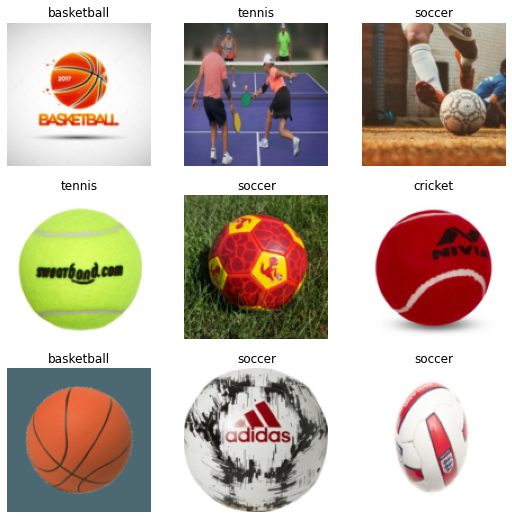

In [27]:
##
# Step: Show a small batch
dls.valid.show_batch(max_n=9, nrows=3)

This is a very convienient function from fastai where you can quickly verify a sample from the training dataset. You can also check here that all the images are of same size and have been properly labelled. Let's quickly check the docs for this function.

In [29]:
#collapse-output
?TfmdDL.show_batch

Signature:
TfmdDL.show_batch(
    self,
    b=None,
    max_n: 'int' = 9,
    ctxs=None,
    show: 'bool' = True,
    unique: 'bool' = False,
    **kwargs,
)
Docstring: Show `b` (defaults to `one_batch`), a list of lists of pipeline outputs (i.e. output of a `DataLoader`)
File:      /opt/conda/lib/python3.8/site-packages/fastai/data/core.py
Type:      function


**Summary of the functions used till now**
* `DataBlock`: Is from fastai data module. It is a generic container to build `DataLoaders`
* `DataBlock.dataloaders(Path)`: to create a `DataLoaders` object from `DataBlock`

**Summary of the steps till now**

In [28]:
# train an image classifier

In [29]:
import time
start_time = time.time()

In [30]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.713641,0.567357,0.205298,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.606930,0.493678,0.165563,00:35
1,0.444930,0.460716,0.145695,00:36
2,0.321523,0.478980,0.152318,00:36


In [31]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 135.6511733531952 seconds ---


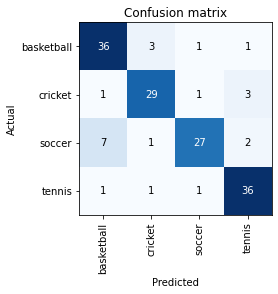

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

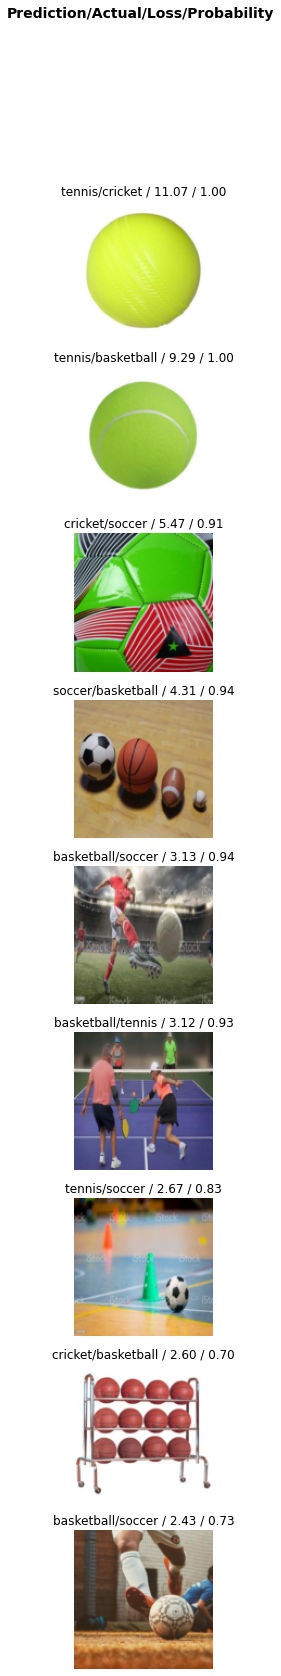

In [33]:
interp.plot_top_losses(9, nrows=9)

In [34]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner